Построить 5 графиков по выбранным данным. 

Графики должны быть различных видов и использовать хотя бы 3 из рассмотренных на занятии библиотек. 

Для каждого описать, какого типа переменные участвуют в визуализации, какова её цель (например, посмотреть на корреляцию двух величин или на распределение значений) и почему выбрали именно такой тип графика.

In [60]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%pylab inline
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 6,3
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from geopy.distance import vincenty

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('../../taxi.csv')
print(df.shape)

(1458644, 11)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [7]:
df.trip_duration.describe(percentiles=(0.05,0.25,0.5, 0.75, 0.95, 0.99, 0.999))

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
5%       1.800000e+02
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
95%      2.104000e+03
99%      3.440000e+03
99.9%    8.512836e+04
max      3.526282e+06
Name: trip_duration, dtype: float64

In [13]:
df = df[df['trip_duration']<=3.440000e+03]
df.trip_duration.describe()

count    1.444069e+06
mean     8.074884e+02
std      5.754915e+02
min      1.000000e+00
25%      3.950000e+02
50%      6.560000e+02
75%      1.058000e+03
max      3.440000e+03
Name: trip_duration, dtype: float64

Отобразим распределение времени поездки для 99% дисперсии гистограмой

Text(0.5,0,'Trip duration in sec')

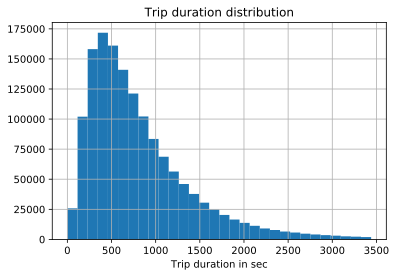

In [11]:
ax = df.trip_duration.hist(bins=30)
ax.set_title('Trip duration distribution')
ax.set_xlabel('Trip duration in sec')

In [14]:
# get vincenty distance between two points
def compute_dist_in_km(coords1, coords2):
    return vincenty(coords1, coords2).kilometers

In [15]:
df['dist_in_km'] = df.apply(lambda row: compute_dist_in_km(
            (row.pickup_latitude, row.pickup_longitude),
            (row.dropoff_latitude, row.dropoff_longitude)
        ), axis=1)

In [18]:
df['velocity'] = df.apply(lambda row: row.dist_in_km/(row.trip_duration/3600), axis=1)

In [25]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df.loc[:, 'pick_date'] = df['pickup_datetime'].dt.date

In [32]:
df.loc[:, 'pick_dayofweek'] = df['pickup_datetime'].dt.dayofweek
df.loc[:, 'pick_hour'] = df['pickup_datetime'].dt.hour
df.loc[:, 'pick_month'] = df['pickup_datetime'].dt.month

In [55]:
df1 = df.groupby('pick_hour')['velocity'].mean().reset_index()

Визуализируем среднюю скорость в зависимости от часа суток

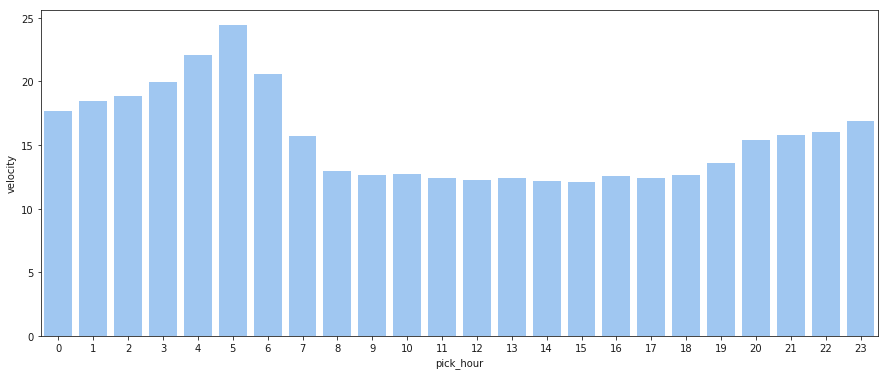

In [53]:
%config InlineBackend.figure_format = 'png'
f, ax = plt.subplots(figsize=(15, 6))
sns.set_color_codes("pastel")
sns.barplot(x="pick_hour", y="velocity", data=df1,
            label="velocity", color="b")

Проверим наличие зависимости расстояния поездки и длительности поездки, а также посмотрим на распределение величин

/home/pavel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/home/pavel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



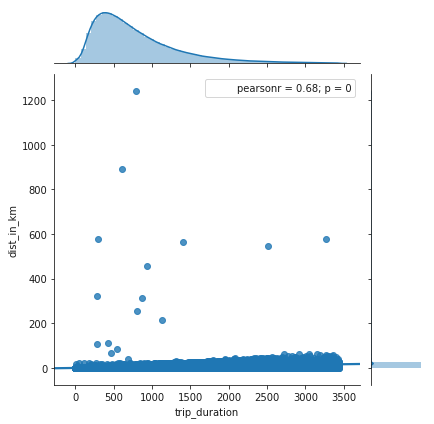

In [54]:
sns.jointplot(x='trip_duration', y='dist_in_km', 
              data=df, kind='reg');

In [58]:
dynamics_df_v1 = df[df['vendor_id']==1].groupby('pick_date')[['id']].count()
dynamics_df_v2 = df[df['vendor_id']==2].groupby('pick_date')[['id']].count()

In [63]:
Построим динамику поездок по дням и по вендорам

SyntaxError: invalid syntax (<ipython-input-63-36a90d878fc1>, line 1)

In [64]:
trace0 = go.Scatter(
    x=dynamics_df_v1.index,
    y=dynamics_df_v1.id,
    name='Vendor 1'
)

trace1 = go.Scatter(
    x=dynamics_df_v2.index,
    y=dynamics_df_v2.id,
    name='Vendor 2'
)

data = [trace0, trace1]
layout = {'title': 'Statistics of trips'}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)

Построим heatmap основных локаций вызова такси. Желтым подсветим 50+ вызовов, 10-50 - зеленым, <10 - красным

In [72]:
rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 0
rgb[..., 1] = 0
rgb[..., 2] = 0
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df['pick_lat_new'] = list(map(int, (df['pickup_latitude'] - (40.6000))*10000))
df['drop_lat_new'] = list(map(int, (df['dropoff_latitude'] - (40.6000))*10000))
df['pick_lon_new'] = list(map(int, (df['pickup_longitude'] - (-74.050))*10000))
df['drop_lon_new'] = list(map(int, (df['dropoff_longitude'] - (-74.050))*10000))

plot = pd.DataFrame(df.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

plot.reset_index(inplace = True)
l_list = plot['pick_lat_new'].unique()

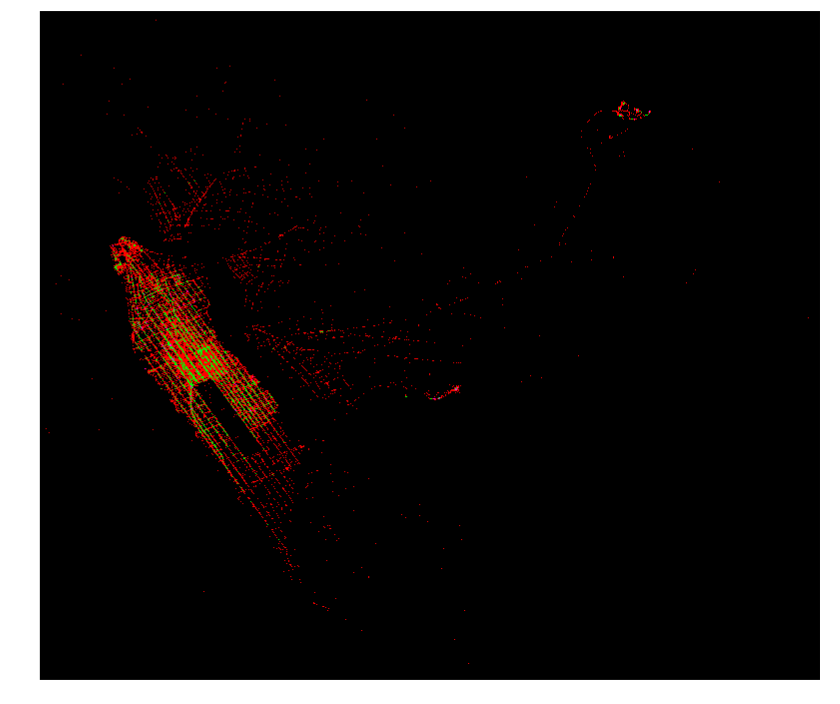

In [73]:
for i in l_list:
    lon_list = plot.loc[plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = plot.loc[plot['pick_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//50) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 255
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off() 